In [1]:
import numpy as np
import pandas as pd
import pingouin as pg
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from dual_data_utils import make_clean_concat_data
from stopsignalmetrics import StopData, SSRTmodel

/Users/henrymj/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Read in and Compute Metrics on Data

In [2]:
OUTLIER_THRESH  = 3
SSD_THRESH = 200

dual_dict = {
    'stop_signal_with_cued_task_switching': {
        'dual_col': 'cue_task_switch',
        'DC': 'cue_stay_task_stay',
        'DE': 'cue_switch_task_switch',
        'OTHER': ['cue_switch_task_stay']
    },
    'stop_signal_with_directed_forgetting': {
        'dual_col': 'directed_forgetting_condition',
        'DC': 'con',
        'DE': 'neg',
        'OTHER': ['pos']
    },
    'stop_signal_with_flanker': {
        'dual_col': 'flanker_condition',
        'DC': 'congruent',
        'DE': 'incongruent'
    },
    'stop_signal_with_go_no_go': {
        'dual_col': 'go_nogo_condition',
        'DC': 'go',
        'DE': 'nogo'
    },
    'stop_signal_with_n_back': {
        'dual_col': 'delay_condition',
        'DC': 1.,
        'DE': 2.,
        'OTHER': [3.]
    },
    'stop_signal_with_predictable_task_switching': {
        'dual_col': 'predictable_condition',
        'DC': 'stay',
        'DE': 'switch'
    },
    'stop_signal_with_shape_matching': {
        'dual_col': 'shape_matching_condition',
        'DC': 'CONTROL',
        'DE': 'DISTRACTOR',
        'OTHER': ['DSD', 'SSS']
    },
}

stopmetrics_var_dict = {
    'columns': {
        'ID': 'worker_id',
        'block': 'current_block',
        'condition': 'SS_trial_type',
        'SSD': 'SS_delay',
        'goRT': 'rt',
        'stopRT': 'rt',
        'response': 'key_press',
        'correct_response': 'choice_correct_response',
        'choice_accuracy': 'choice_accuracy'},
    'key_codes': {
        'go': 'go',
        'stop': 'stop',
        'correct': 1,
        'incorrect': 0,
        'noResponse': -1}}

In [3]:
def get_query_str(col, condition):
    if type(condition)==str:
        return "%s=='%s'" % (col, condition)
    elif type(condition) in [float, int]:
        return "%s==%s" % (col, condition)
    elif type(condition)==list:
        return "%s in %s" % (col, condition)

def stop_summarize(curr_data, thresh=SSD_THRESH, query_str=None):
    data_df = curr_data.query(query_str) if query_str is not None else curr_data
    
    sum_df = SSRTmodel().fit_transform(data_df, level='group')
    sum_df_threshSSDs = SSRTmodel().fit_transform(data_df.query(f'SSD>={thresh} or condition=="go"'), level='group').add_suffix('_wThresh_SSDs')
    sum_df_threshSubs = sum_df.query(f"mean_SSD >= {thresh}").add_suffix('_wThresh_subs')
    return pd.concat([sum_df, sum_df_threshSSDs, sum_df_threshSubs],
                       1,
                       sort=True
                      )

def get_inhib_func(curr_data, cond):
    inhib_df = pd.DataFrame(curr_data.groupby(['ID', 'SSD']).apply(lambda x: x.stopRT.notnull().sum()/len(x))).reset_index()
    inhib_df['condition'] = cond
    return inhib_df

def get_gng_presp(curr_data):
    curr_data = curr_data.copy()
    stop_trials = curr_data.query("stop_signal_condition=='stop'")
    out={}
    out['p_resp'] = (stop_trials.rt != -1).sum()/len(stop_trials)
    out['p_resp_go'] = (stop_trials.query("go_nogo_condition=='go'").rt != -1).sum()/len(stop_trials.query("go_nogo_condition=='go'"))
    out['p_resp_nogo'] = (stop_trials.query("go_nogo_condition=='nogo'").rt != -1).sum()/len(stop_trials.query("go_nogo_condition=='nogo'"))
    return out

In [4]:
stop_data_dict = make_clean_concat_data(stop_subset=True)

# Check P(resp|signal) in Go/NoGo 

In [5]:
gng_presp_data = pd.DataFrame(list(stop_data_dict['stop_signal_with_go_no_go'].groupby('worker_id').apply(get_gng_presp)))
gng_presp_data.describe()

,p_resp,p_resp_go,p_resp_nogo
count,33.000000,33.000000,33.000000
mean,0.431818,0.501263,0.015152
std,0.013957,0.014896,0.038497
min,0.378571,0.441667,0.000000
25%,0.428571,0.491667,0.000000
50%,0.428571,0.500000,0.000000
75%,0.442857,0.508333,0.000000
max,0.457143,0.525000,0.200000


In [6]:
del stop_data_dict['stop_signal_with_go_no_go']

# Get SSRT metrics for remaining tasks

In [7]:
# build dict
ssrtc_out = {}
for task_name in stop_data_dict.keys():  # [k for k in stop_data_dict.keys()][:1]:  # development loop using just 1st task
    curr_data = StopData(stopmetrics_var_dict).fit_transform(stop_data_dict[task_name].drop(columns=['correct_response']))
    short_name = task_name.split('_with_')[-1]
    ssrtc_out[short_name] = stop_summarize(curr_data)
    
    if 'with' in task_name:
        dual_col = dual_dict[task_name]['dual_col']
        for key in [k for k in dual_dict[task_name] if k!='dual_col']:
            query_str = get_query_str(dual_col, dual_dict[task_name][key])
            ssrtc_out['%s_%s' % (short_name,key)] = stop_summarize(
                curr_data,
                query_str=query_str
            )

ssrtc_out['SE'] = ssrtc_out.pop('stop_signal_single_task_network')
metrics = [c for c in ssrtc_out['SE'].columns if 'max_RT' not in c]

#flatten data, remove outliers w/ values > 3 SDs from the mean
flattened_data = pd.concat([ssrtc_out[k].add_prefix(k+'_') for k in ssrtc_out], axis=1, sort=True)
flattened_data = flattened_data.filter(regex='SE|DC|DE', axis=1)
z_df = flattened_data.apply(stats.zscore).apply(np.abs)
flattened_data[z_df>OUTLIER_THRESH] = None
flattened_data.index.name='ID'



SSRTs = flattened_data.loc[:, ~flattened_data.columns.str.contains("wThresh")].filter(regex='SSRT')
SSRTs_ThreshSSDs = flattened_data.loc[:, flattened_data.columns.str.contains("wThresh_SSDs")].filter(regex='SSRT')
SSRTs_ThreshSubs = flattened_data.loc[:, flattened_data.columns.str.contains("wThresh_subs")].filter(regex='SSRT')

# Validation Analyses

In [8]:
old_nSubs = len(SSRTs)
SSRTs = SSRTs.dropna()
new_nSubs = len(SSRTs)
print(f'{old_nSubs-new_nSubs} subs dropped for nan cell')

2 subs dropped for nan cell


# One-way Anova

In [9]:
SSRTs_taskMeaned = pd.DataFrame()
for task_name in stop_data_dict.keys():
    short_name = task_name.split('_with_')[-1]
    if short_name == 'stop_signal_single_task_network':
        SSRTs_taskMeaned['SE'] = SSRTs.filter(regex='SE')
    else:
        SSRTs_taskMeaned[short_name] = SSRTs.filter(regex=short_name).mean(1)
SSRTs_taskMeaned.head()

,predictable_task_switching,n_back,flanker,shape_matching,cued_task_switching,SE,directed_forgetting
ID,,,,,,,
s005,209.25,196.016129,205.00,189.666667,205.25,170.166667,316.25
s010,257.75,267.629032,267.50,317.250000,271.25,254.083333,351.75
s025,301.50,307.663306,295.50,316.583333,325.25,247.500000,392.00
s044,267.50,279.854839,211.75,299.083333,284.00,254.833333,349.25
s066,192.00,249.377016,262.25,217.416667,254.00,347.583333,271.50


In [10]:
melted_SSRTs = SSRTs_taskMeaned.reset_index().melt(id_vars='ID')
melted_SSRTs

,ID,variable,value
0,s005,predictable_task_switching,209.25
1,s010,predictable_task_switching,257.75
2,s025,predictable_task_switching,301.50
3,s044,predictable_task_switching,267.50
4,s066,predictable_task_switching,192.00
...,...,...,...
212,s429,directed_forgetting,286.00
213,s441,directed_forgetting,293.50
214,s454,directed_forgetting,463.25
215,s490,directed_forgetting,376.50


In [11]:
anova_res = pg.rm_anova(data=melted_SSRTs, dv='value', within='variable', subject='ID', detailed=True)
anova_res

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,256719.517784,6,42786.586297,27.577007,3.245425e-23,3.859356e-16,0.478959,0.661857,False,0.205375,0.001602
1,Error,279275.609783,180,1551.531165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Planned Contrasts

Guidelines from [here](http://web.pdx.edu/~newsomj/uvclass/ho_planned%20contrasts.pdf)

In [12]:
df = anova_res.loc[anova_res.Source=='Error', 'DF'].values[0]

In [13]:
MS = anova_res.loc[anova_res.Source=='Error', 'MS'].values[0]
std_err = np.sqrt(MS * (2/len(SSRTs)))
std_err

10.004938024217607

In [14]:
for task in ['directed_forgetting', 'n_back', 'cued_task_switching', 'shape_matching']:
    diff = np.mean(SSRTs_taskMeaned.filter(regex=task).values - SSRTs_taskMeaned.filter(regex='SE').values)
    t = diff/std_err
    pval = stats.t.sf(t, df) 
    print(f'{task}: Mean={diff:.2f}, t={t:.3f}, p={pval:.6f}')

directed_forgetting: Mean=108.87, t=10.882, p=0.000000
n_back: Mean=37.68, t=3.766, p=0.000112
cued_task_switching: Mean=29.84, t=2.983, p=0.001627
shape_matching: Mean=28.56, t=2.855, p=0.002408


## Planned related-samples t-test for n-Back load

In [15]:
diff_SSRTs = SSRTs.sub(SSRTs.filter(regex='SE').values)
del diff_SSRTs['SE_SSRT']

In [16]:
t, pval = stats.ttest_rel(diff_SSRTs.n_back_DE_SSRT.values, diff_SSRTs.n_back_DC_SSRT.values, nan_policy='raise', alternative='greater')
print(f'n-Back DE > DC: Mean={np.mean(diff_SSRTs.n_back_DE_SSRT.values - diff_SSRTs.n_back_DC_SSRT.values):.2f}, t={t:.3f}, p={pval:.6f}')

n-Back DE > DC: Mean=32.95, t=2.654, p=0.006297


# Visualize

In [17]:
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
palette ={"DC":"C0", "DE":"C1", "SE":"C2"}
order_dict = {
    'SE': 'aa',
    'go_no_go': 'ab',
    'predictable_task_switching': 'ba',
    'cued_task_switching': 'bb',
    'flanker': 'ca',
    'shape_matching': 'cb',
    'n_back': 'da',
    'directed_forgetting': 'db'
}

def context_str(string):
    if 'DC' in string:
        return 'DC'
    elif 'DE' in string:
        return 'DE'
    elif 'SE' in string:
        return 'SE'
    elif 'OTHER' in string:
        return 'POS/3BACK/DSD|SSS/CUE_SWITCH'
    else:
        return 'COMBINE'

In [29]:
melted_diffs = diff_SSRTs.reset_index().melt(id_vars='ID', value_name='dual task SSRT - single task SSRT')
melted_diffs['task'] = [i.split('_SSRT')[0].replace('_DC', '').replace('_DE', '') for i in melted_diffs['variable']]
melted_diffs['context'] = [context_str(i) for i in melted_diffs['variable']]
melted_diffs.loc[melted_diffs['task']=='SE', 'context'] = 'SE'

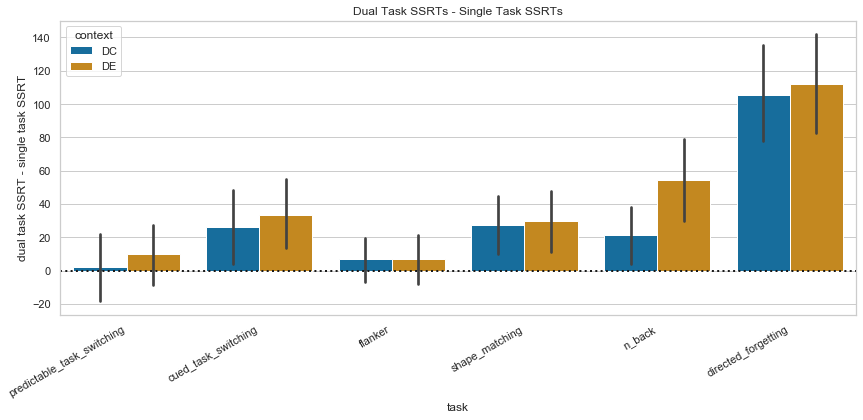

In [31]:
fig = plt.figure(figsize=(12,6))
melted_diffs['order'] = melted_diffs['task'].map(order_dict)
melted_diffs = melted_diffs.sort_values(['order', 'context'])
ax = sns.barplot(x='task', y='dual task SSRT - single task SSRT', hue='context', data=melted_diffs, palette=palette)
_ = plt.xticks(rotation=30, ha='right')
lowx, highx = plt.xlim()
plt.plot([lowx, highx],[0,0],color='k',linestyle=':',linewidth=2)
plt.title('Dual Task SSRTs - Single Task SSRTs')
plt.tight_layout()
lowy, highy = plt.ylim()
_ = plt.axis([lowx, highx, lowy, highy])
plt.savefig('figures/dataset-discovery_metric-SSRT_barplot.png', dpi=300)
plt.show()
plt.close()

# Repetitions with Exclusions

In [20]:
def pipeline(SSRTs, strip_str=''):
    SSRTs = SSRTs.copy()
    SSRTs.columns = [c.replace(strip_str, '') for c in SSRTs.columns]
    
    old_nSubs = len(SSRTs)
    SSRTs = SSRTs.dropna()
    new_nSubs = len(SSRTs)
    print(f'{old_nSubs-new_nSubs} subs dropped for nan cell')

    # One-way ANOVA
    SSRTs_taskMeaned = pd.DataFrame()
    for task_name in stop_data_dict.keys():
        short_name = task_name.split('_with_')[-1]
        if short_name == 'stop_signal_single_task_network':
            SSRTs_taskMeaned['SE'] = SSRTs.filter(regex='SE')
        else:
            SSRTs_taskMeaned[short_name] = SSRTs.filter(regex=short_name).mean(1)
    melted_SSRTs = SSRTs_taskMeaned.reset_index().melt(id_vars='ID')
    anova_res = pg.rm_anova(data=melted_SSRTs, dv='value', within='variable', subject='ID', detailed=True)
    display(anova_res)

    # Planned Contrasts
    df = anova_res.loc[anova_res.Source=='Error', 'DF'].values[0]
    MS = anova_res.loc[anova_res.Source=='Error', 'MS'].values[0]
    std_err = np.sqrt(MS * (2/len(SSRTs)))
    for task in ['directed_forgetting', 'n_back', 'cued_task_switching', 'shape_matching']:
        diff = np.mean(SSRTs_taskMeaned.filter(regex=task).values - SSRTs_taskMeaned.filter(regex='SE').values)
        t = diff/std_err
        pval = stats.t.sf(t, df) 
        print(f'{task}: Mean={diff:.2f}, t={t:.3f}, p={pval:.6f}')

    # n-Back t-test
    diff_SSRTs = SSRTs.sub(SSRTs.filter(regex='SE').values)
    del diff_SSRTs['SE_SSRT']
    
    t, pval = stats.ttest_rel(diff_SSRTs.n_back_DE_SSRT.values, diff_SSRTs.n_back_DC_SSRT.values, nan_policy='raise', alternative='greater')
    print(f'n-Back DE > DC: Mean={np.mean(diff_SSRTs.n_back_DE_SSRT.values - diff_SSRTs.n_back_DC_SSRT.values):.2f}, t={t:.3f}, p={pval:.6f}')

    # Visualization
    melted_diffs = diff_SSRTs.reset_index().melt(id_vars='ID')
    melted_diffs['task'] = [i.split('_SSRT')[0].replace('_DC', '').replace('_DE', '') for i in melted_diffs['variable']]
    melted_diffs['context'] = [context_str(i) for i in melted_diffs['variable']]
    melted_diffs.loc[melted_diffs['task']=='SE', 'context'] = 'SE'
    
    fig = plt.figure(figsize=(12,6))
    melted_diffs['order'] = melted_diffs['task'].map(order_dict)
    melted_diffs = melted_diffs.sort_values(['order', 'context'])
    ax = sns.barplot(x='task', y='value', hue='context', data=melted_diffs, palette=palette)
    _ = plt.xticks(rotation=30, ha='right')
    lowx, highx = plt.xlim()
    plt.plot([lowx, highx],[0,0],color='k',linestyle=':',linewidth=2)
    plt.title('Dual Task SSRTs - Single Task SSRTs')
    plt.tight_layout()
    lowy, highy = plt.ylim()
    _ = plt.axis([lowx, highx, lowy, highy])
    plt.show()
    plt.close()

# Exclude Short SSD trials

7 subs dropped for nan cell


,Source,SS,DF,MS,F,p-unc,np2,eps
0,variable,39851.690167,6,6641.948361,4.499371,0.00032,0.152524,0.789274
1,Error,221429.210679,150,1476.194738,NaN,NaN,NaN,NaN


directed_forgetting: Mean=36.95, t=3.468, p=0.000342
n_back: Mean=35.97, t=3.375, p=0.000470
cued_task_switching: Mean=23.18, t=2.175, p=0.015601
shape_matching: Mean=21.35, t=2.003, p=0.023477
n-Back DE > DC: Mean=39.17, t=2.895, p=0.003877


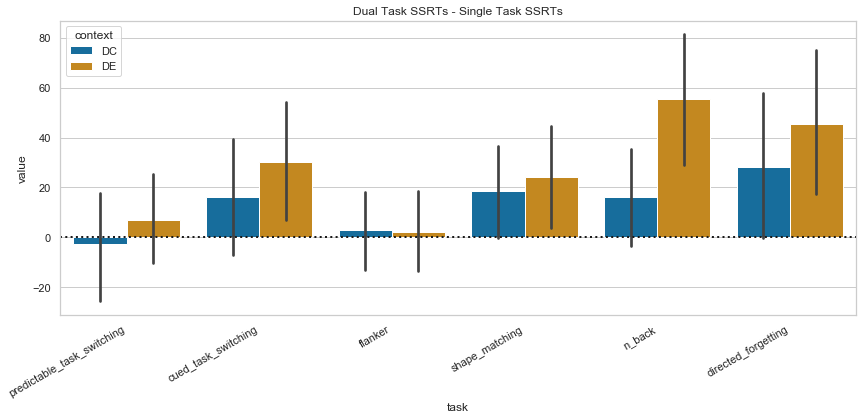

In [21]:
pipeline(SSRTs_ThreshSSDs, strip_str='_wThresh_SSDs')

# Exclude Short SSD subjects

16 subs dropped for nan cell


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,58986.719851,6,9831.119975,6.661342,0.000006,0.000112,0.293952,0.69828,False,0.091164,0.037585
1,Error,141681.280530,96,1475.846672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


directed_forgetting: Mean=61.50, t=4.668, p=0.000005
n_back: Mean=32.12, t=2.438, p=0.008312
cued_task_switching: Mean=21.81, t=1.655, p=0.050548
shape_matching: Mean=11.35, t=0.862, p=0.195532
n-Back DE > DC: Mean=32.44, t=1.915, p=0.036774


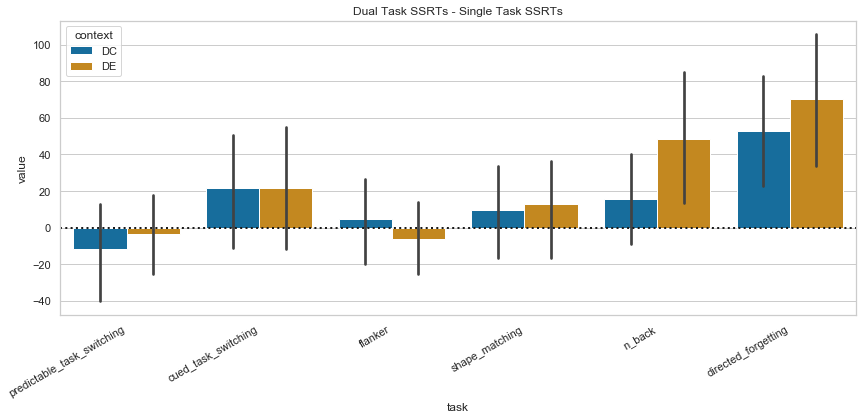

In [22]:
pipeline(SSRTs_ThreshSubs, strip_str='_wThresh_subs')